In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, log_loss, confusion_matrix, ConfusionMatrixDisplay
import time


# 1. Load and Preprocess the Data


In [2]:
csv_path = "Crime_Incidents_20250201.csv"
df = pd.read_csv(csv_path)

df.drop(columns=['Incident ID', 'updated_at'], inplace=True)
df['Incident Datetime'] = pd.to_datetime(df['Incident Datetime'], errors='coerce')
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
df.dropna(subset=['Address', 'Latitude', 'Longitude'], inplace=True)

categorical_cols = ['zip_code', 'neighborhood', 'Council District', 'Council District 2011', 'Census Tract', 'Census Block Group', 'Census Block', 'Police District']
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip().str.lower()

numerical_cols = ['Latitude', 'Longitude', 'Hour of Day']
for col in numerical_cols:
    C1 = df[col].quantile(0.25)
    C3 = df[col].quantile(0.75)
    Iqr = C3 - C1
    lower_bound = C1 - 1.5 * Iqr
    upper_bound = C3 + 1.5 * Iqr
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

numeric_df = df.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()
low_correlation_features = correlation_matrix.columns[correlation_matrix.abs().sum() < 0.1]
df.drop(columns=low_correlation_features, inplace=True, errors='ignore')

label_encoder = LabelEncoder()
categorical_features = ['Day of Week', 'Incident Type Primary', 'Parent Incident Type', 'Police District']
for col in categorical_features:
    df[col] = label_encoder.fit_transform(df[col])

df = pd.get_dummies(df, columns=['neighborhood', 'zip_code'], drop_first=True)
scaler = MinMaxScaler()
numerical_features = ['Latitude', 'Longitude', 'Hour of Day']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

<ipython-input-2-e38ac6aa6e13>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


# 2. Prepare Features and Target

In [3]:
X = df.drop(columns=['Incident Type Primary', 'Incident Datetime', 'address'], errors='ignore')
X = X.select_dtypes(include=['number'])
Y = df['Incident Type Primary']

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)
labels = sorted(np.unique(Y_train))

print("Training set shape:", X_train.shape, Y_train.shape)
print("Validation set shape:", X_val.shape, Y_val.shape)
print("Testing set shape:", X_test.shape, Y_test.shape)


Training set shape: (218343, 6) (218343,)
Validation set shape: (46788, 6) (46788,)
Testing set shape: (46788, 6) (46788,)


# 3. Model Training and Evaluation

In [4]:
# Logistic Regression
start_time = time.time()
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, Y_train)
log_reg_pred = log_reg.predict(X_test)
log_reg_acc = accuracy_score(Y_test, log_reg_pred)
log_reg_loss = log_loss(Y_test, log_reg.predict_proba(X_test), labels=labels)
log_reg_time = time.time() - start_time

# Random Forest Classifier
start_time = time.time()
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, Y_train)
rf_clf_pred = rf_clf.predict(X_test)
rf_clf_acc = accuracy_score(Y_test, rf_clf_pred)
rf_clf_loss = log_loss(Y_test, rf_clf.predict_proba(X_test), labels=labels)
rf_clf_time = time.time() - start_time

# Support Vector Classifier
start_time = time.time()
svc = SVC(kernel='linear', probability=True, random_state=42, C=1)
svc.fit(X_train, Y_train)
svc_pred = svc.predict(X_test)
svc_acc = accuracy_score(Y_test, svc_pred)
svc_loss = log_loss(Y_test, svc.predict_proba(X_test), labels=labels)
svc_time = time.time() - start_time

# 4. Neural Netwrok

In [5]:
# Neural Network (PyTorch)
class CrimeNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CrimeNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

start_time = time.time()
n_classes = len(np.unique(Y))
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = CrimeNN(X_train.shape[1], n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()

nn_model_time = time.time() - start_time
nn_pred = model(X_test_tensor).argmax(dim=1)
nn_acc = accuracy_score(Y_test, nn_pred)
nn_loss = criterion(model(X_test_tensor), Y_test_tensor).item()
torch.save(model.state_dict(), "best_nn_weights.pt")

print("Neural Network Accuracy:", nn_acc)
print("Neural Network Loss:", nn_loss)
print("Neural Network Training Time:", nn_model_time)
print("Model weights saved to: best_nn_weights.pt")

Neural Network Accuracy: 0.9886509361374711
Neural Network Loss: 0.05364367365837097
Neural Network Training Time: 273.98107409477234
Model weights saved to: best_nn_weights.pt


# 4. Compare Model Performances

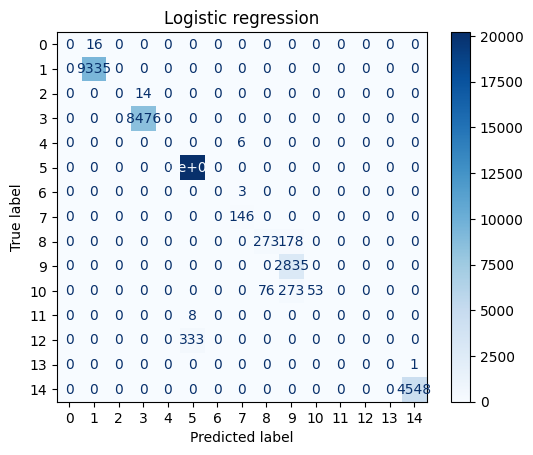

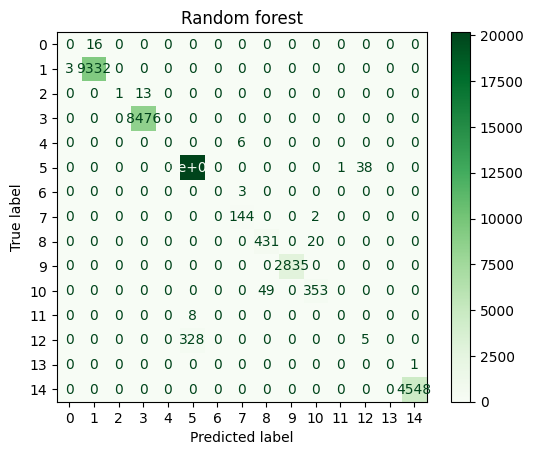

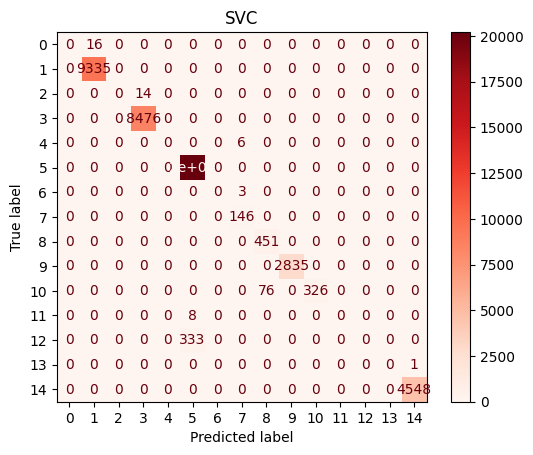

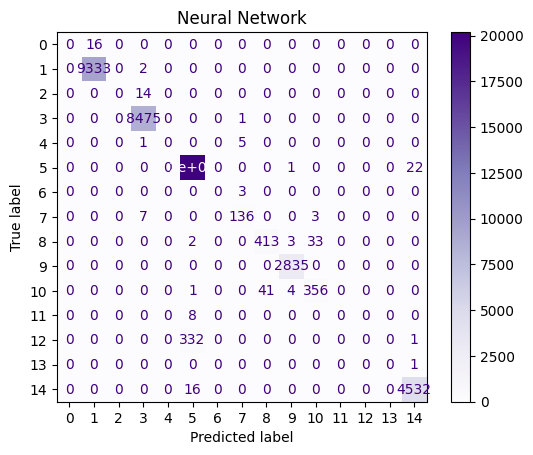

In [7]:
# Logistic Regression - Confusion Matrix
log_reg_cm = confusion_matrix(Y_test, log_reg_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=log_reg_cm)
disp.plot(cmap='Blues')
plt.title('Logistic regression')
plt.show()

# Random Forest
rf_cm = confusion_matrix(Y_test, rf_clf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm)
disp.plot(cmap='Greens')
plt.title('Random forest')
plt.show()

# SVC
svc_cm = confusion_matrix(Y_test, svc_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=svc_cm)
disp.plot(cmap='Reds')
plt.title('SVC')
plt.show()

# Neural Network
nn_pred = model(X_test_tensor).argmax(dim=1).numpy()
nn_cm = confusion_matrix(Y_test, nn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=nn_cm)
disp.plot(cmap='Purples')
plt.title('Neural Network')
plt.show()

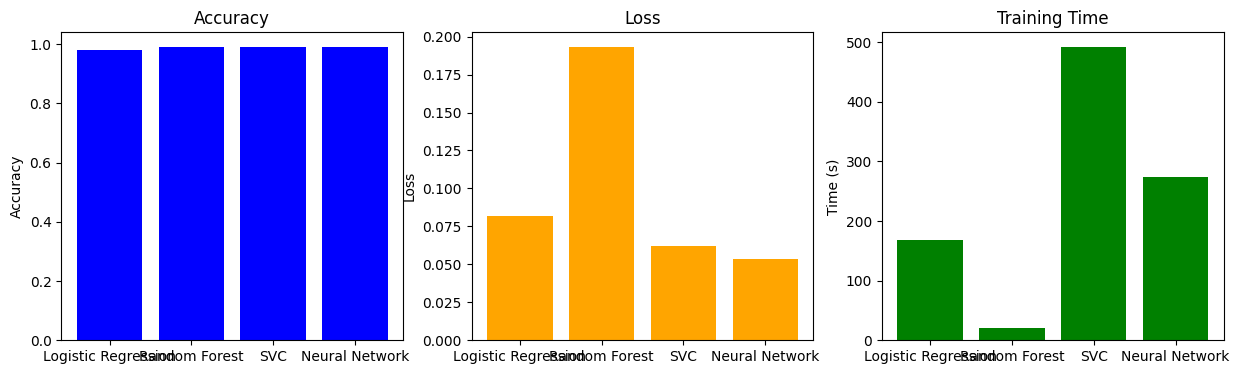

In [8]:
models = ['Logistic Regression', 'Random Forest', 'SVC', 'Neural Network']
accuracies = [log_reg_acc, rf_clf_acc, svc_acc, nn_acc]
losses = [log_reg_loss, rf_clf_loss, svc_loss, nn_loss]
times = [log_reg_time, rf_clf_time, svc_time, nn_model_time]

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.bar(models, accuracies, color='blue')
plt.title('Accuracy')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
plt.bar(models, losses, color='orange')
plt.title('Loss')
plt.ylabel('Loss')

plt.subplot(1, 3, 3)
plt.bar(models, times, color='green')
plt.title('Training Time')
plt.ylabel('Time (s)')
plt.show()

In [9]:
print("\nClassification Report for Logistic Regression:")
print(classification_report(Y_test, log_reg_pred))
print("\nClassification Report for Random Forest:")
print(classification_report(Y_test, rf_clf_pred))
print("\nClassification Report for SVC:")
print(classification_report(Y_test, svc_pred))




Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        16
           2       1.00      1.00      1.00      9335
           3       0.00      0.00      0.00        14
           4       1.00      1.00      1.00      8476
           5       0.00      0.00      0.00         6
           7       0.98      1.00      0.99     20214
           8       0.00      0.00      0.00         3
           9       0.94      1.00      0.97       146
          11       0.78      0.61      0.68       451
          12       0.86      1.00      0.93      2835
          13       1.00      0.13      0.23       402
          16       0.00      0.00      0.00         8
          17       0.00      0.00      0.00       333
          18       0.00      0.00      0.00         1
          19       1.00      1.00      1.00      4548

    accuracy                           0.98     46788
   macro avg       0.50      0.4

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

# 6. Visualizations

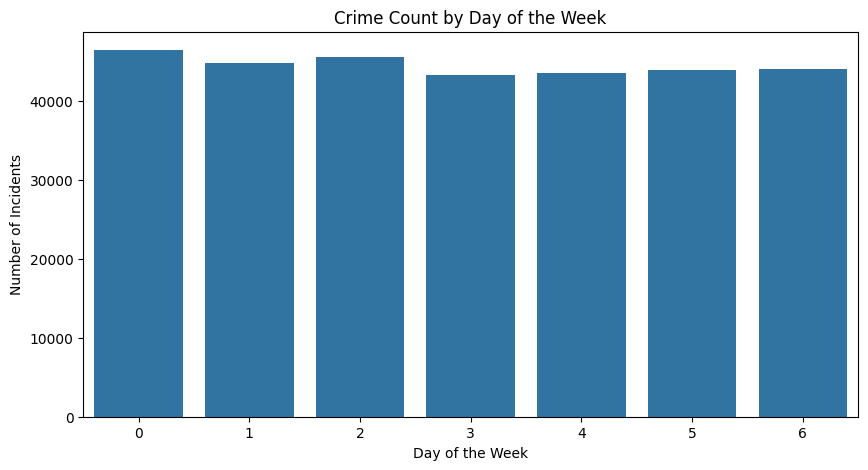

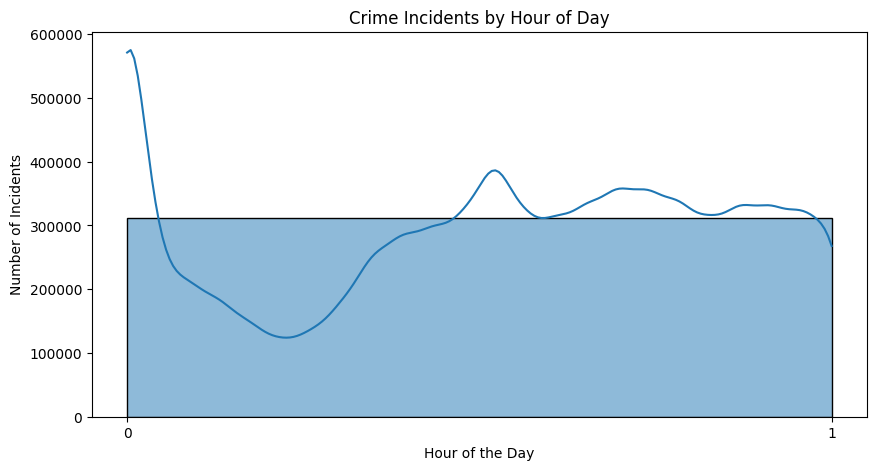

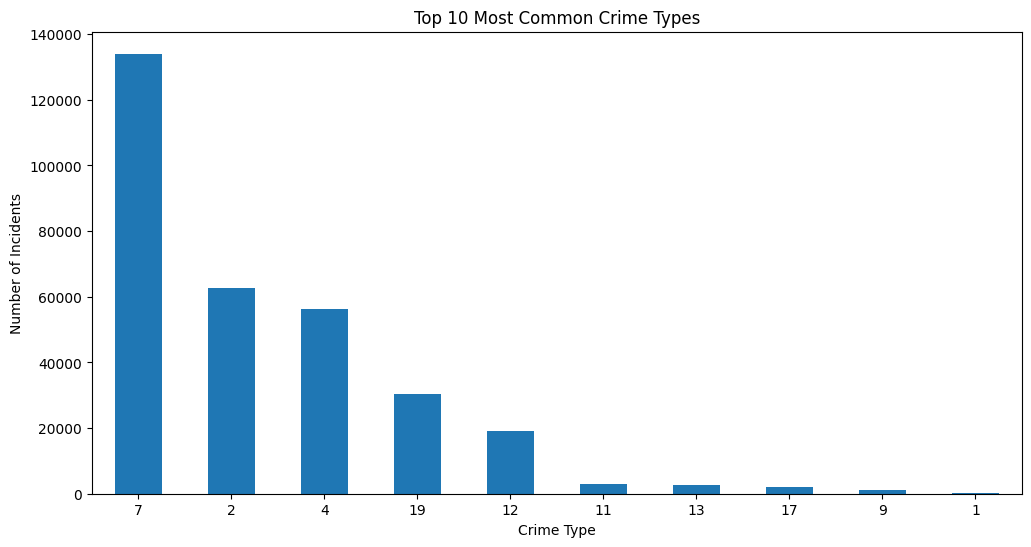

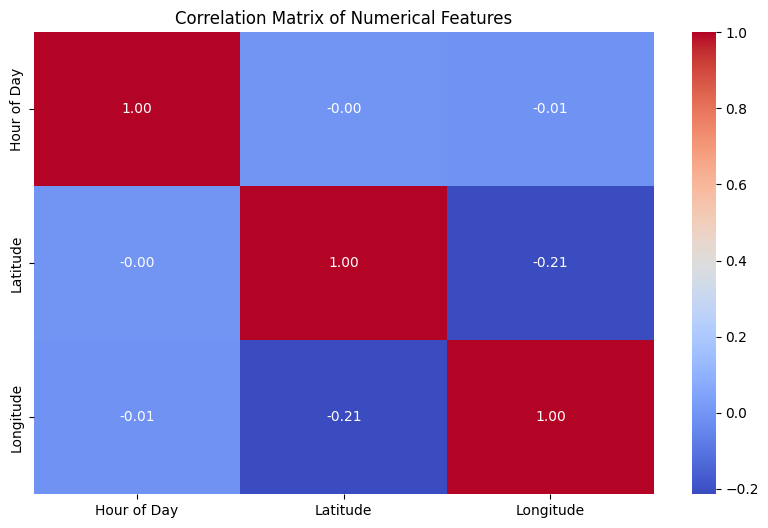

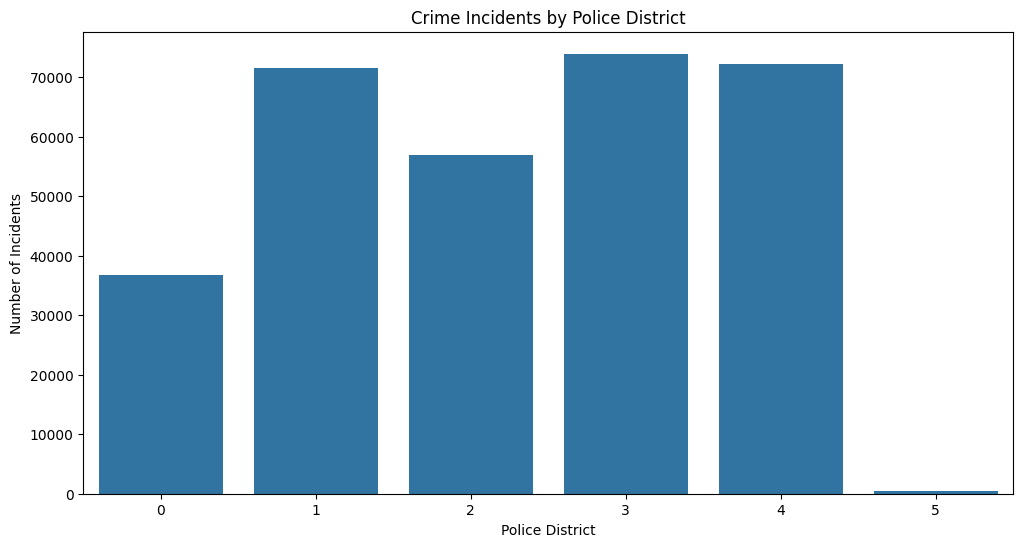

In [10]:
# V1: Crime count by day of the week
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Day of Week')
plt.title('Crime Count by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=0)
plt.show()

# V2: Crime incidients over the hours of the day:
plt.figure(figsize=(10, 5))
sns.histplot(df['Hour of Day'], bins=1, kde=True)
plt.title('Crime Incidents by Hour of Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Incidents')
plt.xticks(range(0, 2))
plt.show()

# V3: Top 10 most common crime types:
plt.figure(figsize=(12, 6))
df['Incident Type Primary'].value_counts().nlargest(10).plot(kind='bar')
plt.title('Top 10 Most Common Crime Types')
plt.xlabel('Crime Type')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=0)
plt.show()

# V4: Heatmap of corelations between numerical features:
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# V5: Crime incidents by Police District
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Police District')
plt.title('Crime Incidents by Police District')
plt.xlabel('Police District')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=0)
plt.show()


